In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats  

In [93]:
# load csv and do data cleaning

df = pd.read_csv('Exam LA1 - Sheet1.csv')

df['Prg'] = df['Prg'].str.strip()
df['Prg'] = df['Prg'].fillna('-')
df['Prg'] = df['Prg'].replace('MD1','MDI')
df['Prg'] = df['Prg'].replace('M1','MDI')
df['Prg'] = df['Prg'].replace('Rh22','-')
df['Prg'] = df['Prg'].replace('Pi','PI')

df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str), format='%Y-%m').astype(str)

df['Pass/Fail'].value_counts()

Pass/Fail
P    1364
U     704
Name: count, dtype: int64

In [94]:
# get dataframe corresponding to Table 1

df['Count'] = 1

# create a pivot table with mean and count
df_pivot = pd.pivot_table(df, values=['Pass/Fail', 'Count'], index=['Prg'], columns=['Date'], aggfunc={'Pass/Fail': lambda x: sum(x == 'P') / len(x), 'Count': len})

# multiply pass/fail by 100 to convert to percentage
df_pivot['Pass/Fail'] = df_pivot['Pass/Fail'] * 100

# create a multi-index header with the mean and count
new_columns = pd.MultiIndex.from_product([['Count','Pass-percentage'], df_pivot['Pass/Fail'].columns])

# assign the new columns to the dataframe
df_pivot.columns = new_columns

# display the new dataframe
print(df_pivot)

df_pivot.to_csv('student_mean_count.csv')


          Count                                                          
Date 2021-08-01 2021-10-01 2022-03-01 2022-04-01 2022-05-01 2023-01-01   
Prg                                                                      
-         143.0        NaN       11.0        1.0        6.0        5.0  \
B           NaN        NaN       52.0       10.0        1.0        2.0   
BI          NaN        NaN       15.0        NaN        2.0        NaN   
BME         NaN        7.0        1.0        3.0       36.0        7.0   
Bi          NaN        5.0       18.0       18.0        2.0        4.0   
C           NaN        4.0        6.0       13.0       11.0       37.0   
D           NaN        8.0        5.0       15.0       77.0       17.0   
E           NaN        1.0       65.0       25.0        3.0       10.0   
F           NaN       81.0        1.0        6.0        3.0        9.0   
I           NaN        3.0       13.0       25.0        NaN      105.0   
K           NaN        NaN       40.0 

In [95]:
# create nested dictionary that maps a problem number of a given exam to a problem category

problem_type_year_dict = {
    '2021-08': {'1': 'Line stuff', '2': 'Solve matrix equation', '3': 'Rank & Null', '4': 'Avbildningsmatrisen', '5': '40x42 matrix','6':'Least squares'},
    '2021-10': {'1': 'Geometric room', '2': 'Line stuff', '3': '40x42 matrix', '4': 'Least squares', '5': 'Avbildningsmatrisen','6':'Eigenvalues'},
    '2022-03': {'1': 'Solve equation system', '2': 'Line stuff', '3': 'Solve matrix equation', '4': 'Rank & Null', '5': 'Least squares','6':'Avbildningsmatrisen'},
    '2022-04': {'1': 'Solve equation system', '2': 'Line stuff', '3': 'Least squares', '4': 'Solve matrix equation', '5': 'Change of Basis','6':'Avbildningsmatrisen'},
    '2022-05': {'1': 'Solve equation system', '2': 'Line stuff', '3': 'Solve matrix equation', '4': 'Least squares', '5': 'Eigenvalues','6':'Avbildningsmatrisen'},
    '2023-01': {'1': 'Solve equation system', '2': 'Line stuff', '3': 'Rank & Null', '4': 'Least squares', '5': 'Eigenvalues','6':'Avbildningsmatrisen'},
    '2023-03': {'1': 'Line stuff', '2':'Rank & Null', '3':'Change of Basis','4':'Least squares','5':'Eigenvalues','6':'Avbildningsmatrisen'}
}

problems = ['Solve matrix equation','Solve equation system','Least squares','Eigenvalues','Line stuff','Avbildningsmatrisen','Rank & Null','40x42 matrix','Geometric room','Change of Basis']
dates = df['Date'].unique().tolist()

In [96]:
def update_row(row):
    # Get the year and month of the exam iteration from the Year and Month columns
    year_month = str(row['Year']) + '-' + str(row['Month']).zfill(2)
    
    # Get the mapping from problem number to problem type for the exam iteration from the nested dictionary
    problem_type_map = problem_type_year_dict.get(year_month)
    
    # Update the columns for each problem type based on the mapping
    for problem_num in problem_type_map:
        problem_type = problem_type_map[problem_num]
        if problem_type in problems:
            column_name = problem_type.replace(' ','_')
            row[column_name] = row[problem_num]
    return row

updated_df = df.apply(update_row, axis = 1)

In [97]:
updated_df = updated_df.drop(['1','2','3','4','5','6','7','8','9','10','Year','Month'], axis=1)

In [99]:
# sort columns to be more human readable
column_order = ['Date','Prg','Pass/Fail','Total1','Solve_matrix_equation','Solve_equation_system','Least_squares','Eigenvalues','Line_stuff','Avbildningsmatrisen','Rank_&_Null','40x42_matrix','Geometric_room','Change_of_Basis']
updated_df = updated_df[column_order]

In [100]:
#calculate relative contributions
problems = ['Solve_matrix_equation','Solve_equation_system','Least_squares','Eigenvalues','Line_stuff','Avbildningsmatrisen','Rank_&_Null','40x42_matrix','Geometric_room','Change_of_Basis']
for problem in problems:
    updated_df[f'{problem}_contribution'] = updated_df[problem]/(updated_df['Total1'])

In [101]:
# create updated version of data set
updated_df.to_csv('Updated_LA1.csv')

In [102]:
# get mean and standard deviation of selected problems for a given exam

numeric_cols = updated_df.select_dtypes(include=[np.number]).columns.tolist()

mean_df = updated_df.groupby(['Date'])[numeric_cols].agg(['mean','std'])
mean_subset_rel = mean_df[['Solve_matrix_equation_contribution','Solve_equation_system_contribution','Least_squares_contribution','Avbildningsmatrisen_contribution','Line_stuff_contribution']]
mean_subset_tot = mean_df[['Solve_matrix_equation','Solve_equation_system','Least_squares','Avbildningsmatrisen','Line_stuff']]

print(mean_subset_tot)

           Solve_matrix_equation           Solve_equation_system             
                            mean       std                  mean       std   
Date                                                                         
2021-08-01              2.447552  0.983514                   NaN       NaN  \
2021-10-01                   NaN       NaN                   NaN       NaN   
2022-03-01              1.936034  1.243858              1.754797  1.104383   
2022-04-01              1.875519  1.061182              1.991701  1.028720   
2022-05-01              1.611429  1.070979              2.337143  0.950223   
2023-01-01                   NaN       NaN              1.958678  1.163891   
2023-03-01                   NaN       NaN                   NaN       NaN   

           Least_squares           Avbildningsmatrisen           Line_stuff   
                    mean       std                mean       std       mean   
Date                                                         

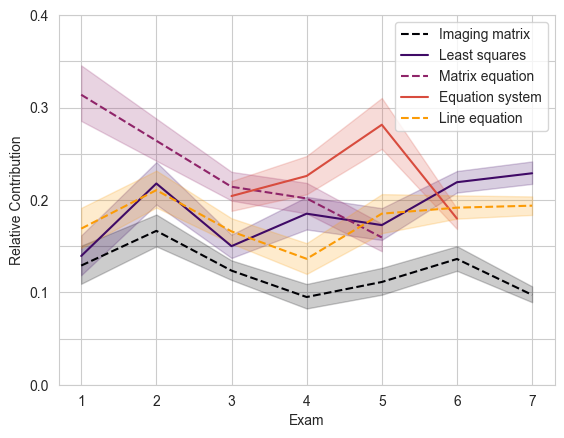

In [116]:
# get plot corresponding to right panel of figure 1

updated_df_sort = updated_df.sort_values(by='Date')

sns.set_style('whitegrid')
sns.lineplot(x = 'Date', y='Avbildningsmatrisen_contribution', data= updated_df_sort,estimator='mean',errorbar='ci',label='Imaging matrix',color='#000004',linestyle='dashed')
sns.lineplot(x = 'Date', y='Least_squares_contribution',data=updated_df_sort,estimator='mean',errorbar='ci', label='Least squares',color='#3f0a66')
sns.lineplot(x = 'Date', y='Solve_matrix_equation_contribution',data=updated_df_sort,estimator='mean',errorbar='ci',label = 'Matrix equation',color='#8f2469',linestyle='dashed')
sns.lineplot(x = 'Date', y='Solve_equation_system_contribution',data=updated_df_sort,estimator='mean',errorbar='ci',label = 'Equation system',color='#d84c3e')
sns.lineplot(x = 'Date', y='Line_stuff_contribution',data=updated_df_sort,estimator='mean',errorbar='ci',label = 'Line equation', color = '#fb9b06',linestyle='dashed')

ticks = ['2021-08-01','2021-10-01','2022-03-01','2022-04-01','2022-05-01','2023-01-01','2023-03-01']
labels = ['1','2','3','4','5','6','7']
plt.xticks(ticks,labels)

ticks = [0.00,0.05,0.10,0.15,0.2,0.25,0.3,0.35,0.4]
labels = ['0.0','','0.1','','0.2','','0.3','','0.4']
plt.yticks(ticks,labels)

plt.ylim(0, 0.4)
plt.xlabel('Exam')

plt.ylabel('Relative Contribution')

plt.savefig('contribution.svg')

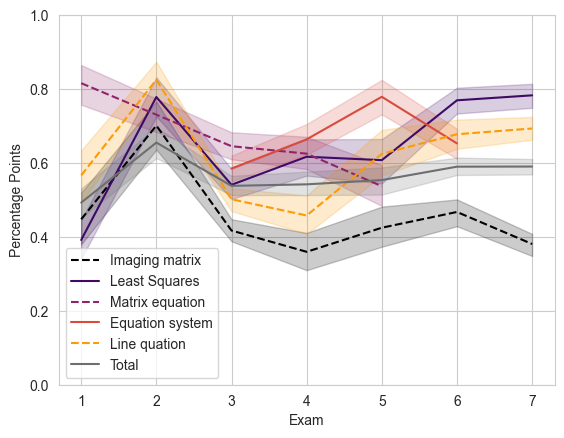

In [117]:
# get plot corresponding to left panel of figure 1

updated_df_sort = updated_df.sort_values(by='Date')
updated_df_sort[['Avbildningsmatrisen','Least_squares','Solve_matrix_equation','Solve_equation_system','Line_stuff']] /= 3
updated_df_sort[['Total1']] /= 18

sns.set_style('whitegrid')

sns.lineplot(x = 'Date', y='Avbildningsmatrisen', data= updated_df_sort,estimator='average',errorbar='ci', label = 'Imaging matrix',color='#000004',linestyle='dashed')
sns.lineplot(x = 'Date', y='Least_squares',data=updated_df_sort,estimator='average',errorbar='ci',label = 'Least Squares',color='#3f0a66')
sns.lineplot(x = 'Date', y='Solve_matrix_equation',data=updated_df_sort,estimator='average',errorbar='ci', label = 'Matrix equation',color='#8f2469',linestyle='dashed')
sns.lineplot(x = 'Date', y='Solve_equation_system',data=updated_df_sort,estimator='average',errorbar='ci', label = 'Equation system',color='#d84c3e')
sns.lineplot(x = 'Date', y='Line_stuff',data=updated_df_sort,estimator='average',errorbar='ci',label = 'Line quation',color='#fb9b06',linestyle='dashed')
sns.lineplot(x = 'Date', y='Total1',data=updated_df_sort,estimator='average',label = 'Total',color='#6e6e6e',markers=True)

#sns.set_palette("inferno")
plt.ylim(0, 1)
plt.xlabel('Exam')
plt.ylabel('Percentage Points')

ticks = ['2021-08-01','2021-10-01','2022-03-01','2022-04-01','2022-05-01','2023-01-01','2023-03-01']
labels = ['1','2','3','4','5','6','7']
plt.xticks(ticks,labels)

plt.savefig('points.svg')

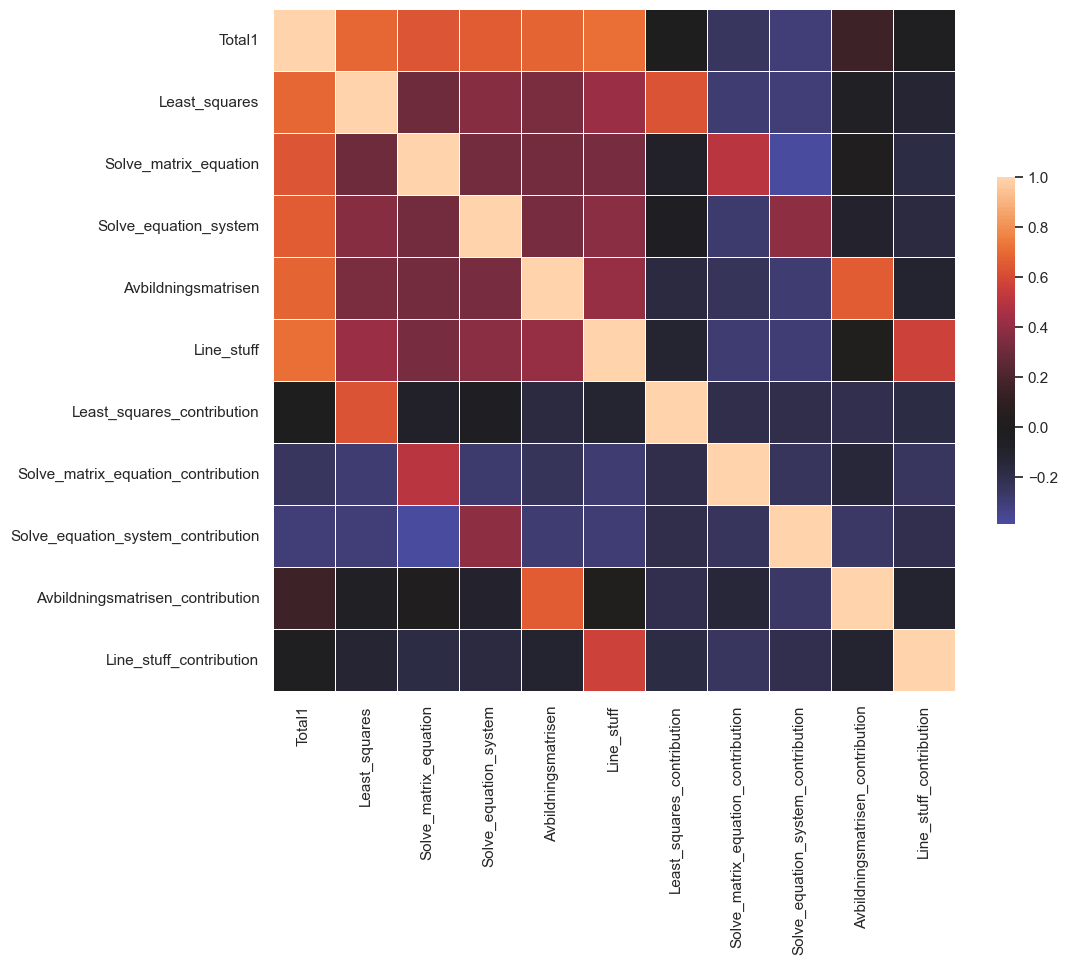

In [95]:
# get correlation map

updated_new = updated_df[['Total1','Least_squares','Solve_matrix_equation','Solve_equation_system','Avbildningsmatrisen','Line_stuff','Least_squares_contribution','Solve_matrix_equation_contribution','Solve_equation_system_contribution','Avbildningsmatrisen_contribution','Line_stuff_contribution']]
corr = updated_new.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230, 20, as_cmap = True)

sns.heatmap(corr,center = 0,
           square = True, linewidths = .5, cbar_kws={"shrink":.5})

plt.savefig('correlation.svg')

In [48]:
# the following is merely a test for some hypothesis testing based on a t-test (assumes normal distribution)
# later uses chi-squared, for a two-point distribution (fail/pass)
# values seem a bit odd, which is why they are not included

first_date = '2021-08-01'
last_date = '2023-03-01'

first_exam_data = updated_df.loc[updated_df['Date'] == first_date,['Least_squares']]
last_exam_data = updated_df.loc[updated_df['Date'] == last_date, ['Least_squares']]

t, p = ttest_ind(first_exam_data, last_exam_data, equal_var=False)

print(t)
print(p)

[-12.50862916]
[3.33519404e-28]


In [58]:
from scipy.stats import shapiro, levene, mannwhitneyu

group1 = updated_df.loc[updated_df['Date'] == first_date, 'Least_squares']
group2 = updated_df.loc[updated_df['Date'] == last_date, 'Least_squares']

stat1, p1 = shapiro(group1)
stat2, p2 = shapiro(group2)

print(stat1, p1)
print(stat2, p2)

stat, p = levene(group1, group2)

print(stat, p)

stat, p = mannwhitneyu(group1, group2)
print(stat, p)

0.7862489223480225 3.617459250985361e-13
0.6228267550468445 5.567396915515657e-32
0.08853598258714397 0.7661411575899653
17089.0 1.2277363609584436e-27


In [61]:
print(group2.mean())
print(group1.mean())

2.348927875243665
1.1748251748251748


In [115]:
from scipy.stats import chi2_contingency
updated_df['lq_pf'] = updated_df['Least_squares'].apply(lambda x: 0 if x <= 0 else 1)
cont_table = pd.crosstab(updated_df['lq_pf'],df['Date'])

new_cont_table = cont_table[['2022-04-01','2022-05-01']]

stat, p, dof, expected = chi2_contingency(new_cont_table)

print(stat, p, dof, expected)

0.0015423160375274336 0.9686732656937544 1 [[ 59.67067308  43.32932692]
 [181.32932692 131.67067308]]
